In [173]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (
    HorizontalFlip,
    ShiftScaleRotate,
    Normalize,
    Resize,
    Compose,
    GaussNoise,
)
#from albumentations.torch import ToTensor
from torchvision.transforms import ToTensor

warnings.filterwarnings("ignore")

In [128]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [174]:
import segmentation_models_pytorch as smp

In [178]:
# sample_submission_path = '../input/siim-acr-pneumothorax-segmentation/sample_submission.csv'
# sample_submission_path = "../input/siim-stage1/sample_submission.csv"


train_rle_path = "./train-rle-100.csv"
#data_folder = "../input/siim-png-images/input/train_png"
data_folder = "./dicom_files"
test_data_folder = "../input/siim-png-images/input/test_png"

In [190]:
from siim_dataset import SIIMDataset, provider



dataloader = provider(
    fold=0,
    total_folds=5,
    data_folder=data_folder,
    df_path=train_rle_path,
    phase="train",
    size=512,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    batch_size=16,
    num_workers=4,
)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [188]:
batch = next(iter(dataloader))  # get a batch from the dataloader
images, masks = batch

python(57354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57379) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [95]:
import pandas as pd

# Iterate through the DataLoader to collect data
all_data = []
for batch_idx, (images, masks) in enumerate(dataloader):
    # Assuming images and masks are PyTorch tensors
    batch_size = images.size(0)  # Get batch size

    # Convert tensors to numpy arrays for easier inspection (if needed)
    images_np = images.numpy()
    masks_np = masks.numpy()

    # Create a dictionary for each batch containing batch index, image, and mask details
    batch_data = {
        "Batch Index": [batch_idx] * batch_size,
        "Image Shape": [image.shape for image in images_np],
        "Mask Shape": [mask.shape for mask in masks_np],
        # You can add more details as needed
    }
    all_data.append(pd.DataFrame(batch_data))

# Concatenate all batch data into a single DataFrame
all_data_df = pd.concat(all_data, ignore_index=True)

# Display the DataFrame
print(all_data_df)

      Batch Index    Image Shape     Mask Shape
0               0  (3, 512, 512)  (1, 512, 512)
1               0  (3, 512, 512)  (1, 512, 512)
2               0  (3, 512, 512)  (1, 512, 512)
3               0  (3, 512, 512)  (1, 512, 512)
4               0  (3, 512, 512)  (1, 512, 512)
...           ...            ...            ...
3801          237  (3, 512, 512)  (1, 512, 512)
3802          237  (3, 512, 512)  (1, 512, 512)
3803          237  (3, 512, 512)  (1, 512, 512)
3804          237  (3, 512, 512)  (1, 512, 512)
3805          237  (3, 512, 512)  (1, 512, 512)

[3806 rows x 3 columns]


TypeError: Invalid shape (512,) for image data

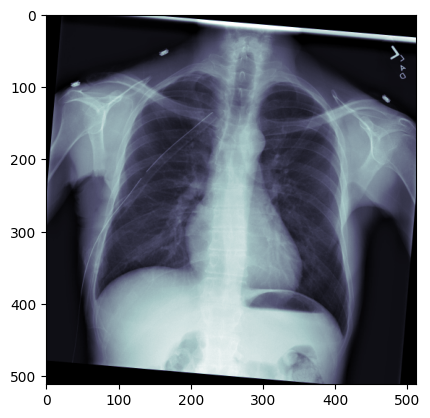

In [189]:
# plot some random images in the `batch`
idx = random.choice(range(16))
plt.imshow(images[idx][0], cmap="bone")
plt.imshow(masks[idx][0], alpha=0.2, cmap="Reds")
plt.show()
if len(np.unique(masks[idx][0])) == 1:  # only zeros
    
    print("Chosen image has no ground truth mask, rerun the cell")

In [140]:
len(masks)

16

In [141]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return (2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError(
                "Target size ({}) must be the same as input size ({})".format(
                    target.size(), input.size()
                )
            )
        max_val = (-input).clamp(min=0)
        loss = (
            input
            - input * target
            + max_val
            + ((-max_val).exp() + (-input - max_val).exp()).log()
        )
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha * self.focal(input, target) - torch.log(
            dice_loss(input, target)
        )
        return loss.mean()

In [142]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype("uint8")
    return preds


def metric(probability, truth, threshold=0.5, reduction="none"):
    """Calculates dice of positive and negative images seperately"""
    """probability and truth must be torch tensors"""
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert probability.shape == truth.shape

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p * t).sum(-1) / ((p + t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        #         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        #         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        #         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos


class Meter:
    """A meter to keep track of iou and dice scores throughout an epoch"""

    def __init__(self, phase, epoch):
        self.base_threshold = 0.5  # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice)
        self.dice_pos_scores.extend(dice_pos)
        self.dice_neg_scores.extend(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou


def epoch_log(phase, epoch, epoch_loss, meter, start):
    """logging the metrics at the end of an epoch"""
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print(
        "Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f"
        % (epoch_loss, dice, dice_neg, dice_pos, iou)
    )
    return dice, iou


def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    """computes iou for one ground truth mask and predicted mask"""
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    """computes mean iou for a batch of ground truth masks and predicted masks"""
    ious = []
    preds = np.copy(outputs)  # copy is imp
    labels = np.array(labels)  # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

# UNet with ResNet34 model¶


In [143]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

In [144]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [148]:

from tqdm import tqdm
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.backends.cudnn as cudnn
import time


class Trainer(object):
    """This class takes care of training and validation of our model"""

    def __init__(self, model):
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size["train"]
        self.lr = 5e-4
        self.num_epochs = 10
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("mps")
        # self.device = torch.device("cuda:0")
        # torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode="min", patience=3, verbose=True
        )
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                fold=1,
                total_folds=5,
                data_folder=data_folder,
                df_path=train_rle_path,
                phase=phase,
                size=512,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}

    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)#.unsqueeze(1)  # (batch_size, 1, 512, 512)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches, desc=f"Epoch {epoch} [{phase}]")
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            #print(f"Batch {itr} - targets shape: {targets.shape}, outputs shape: {outputs.shape}")
            #targets = targets.unsqueeze(1)
            meter.update(targets, outputs)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        # torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()

In [149]:
model_trainer = Trainer(model)
model_trainer.start()
model_trainer.save_model("models/segmentation_restnet34_model.pth")

Starting epoch: 0 | phase: train | ⏰: 19:44:09


Epoch 0 [train]: 100%|██████████| 952/952 [57:35<00:00,  3.63s/it, loss=0.452] 


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3806,) + inhomogeneous part.

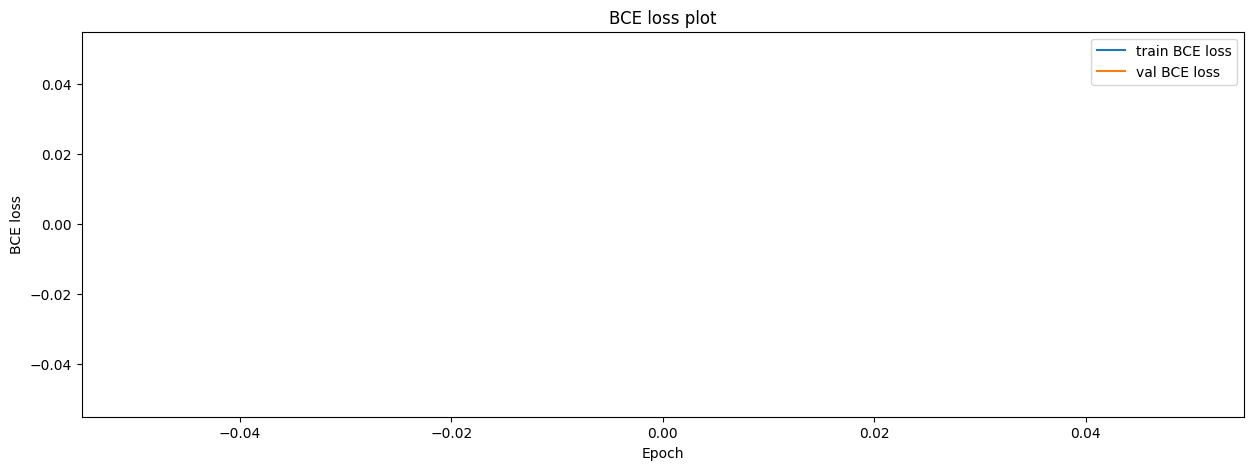

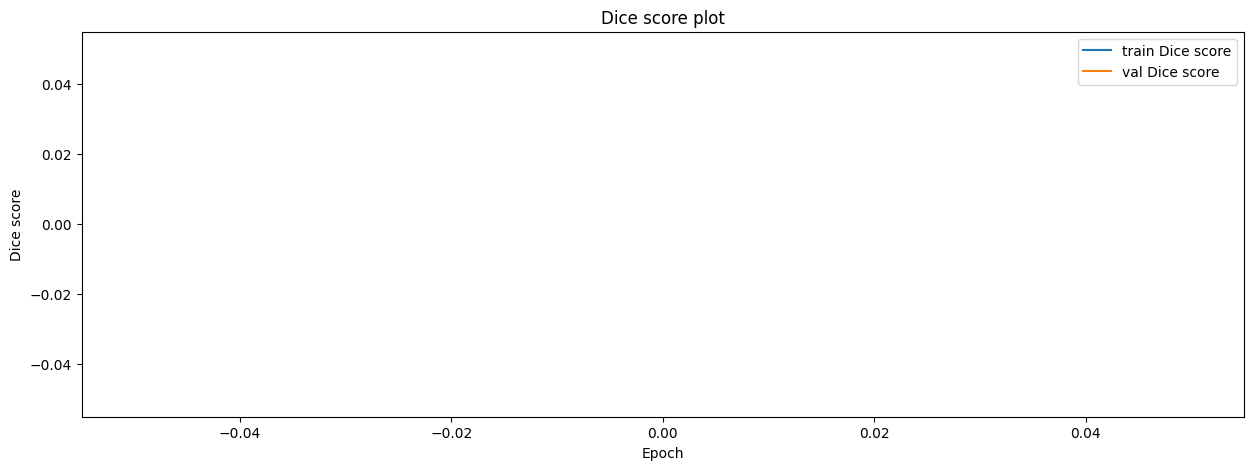

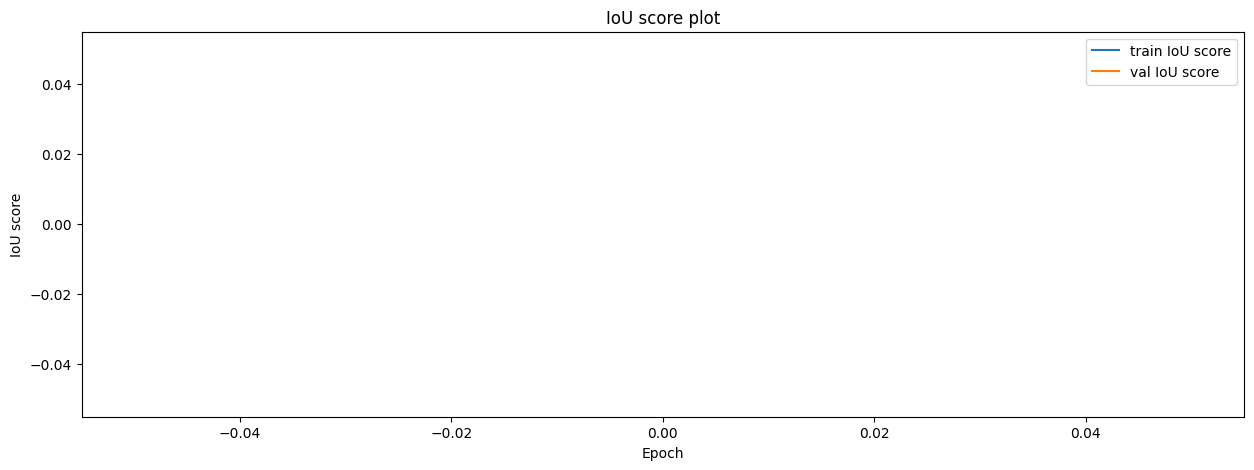

In [ ]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores  # overall dice
iou_scores = model_trainer.iou_scores


def plot(scores, name):
    plt.figure(figsize=(15, 5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f"train {name}")
    plt.plot(range(len(scores["train"])), scores["val"], label=f"val {name}")
    plt.title(f"{name} plot")
    plt.xlabel("Epoch")
    plt.ylabel(f"{name}")
    plt.legend()
    plt.show()


plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")